# Imports

In [1]:
import json
from pathlib import Path
import pickle
from tqdm.auto import tqdm

from haystack.nodes.preprocessor import PreProcessor

In [2]:
proj_dir = Path.cwd().parent
print(proj_dir)

/home/ec2-user/arabic-wiki


# Config

In [3]:
files_in = list((proj_dir / 'data/consolidated').glob('*.ndjson'))
folder_out = proj_dir / 'data/processed'

# Load data

In [4]:
with open(files_in[0], 'r') as f:
    articles = [json.loads(line) for line in f]

In [5]:
from pprint import pprint
article = articles[0].copy()
# Truncate content so it displays well
article['content'] = article['content'][:50] + '...'
pprint(article)

{'content': 'الماء مادةٌ شفافةٌ عديمة اللون والرائحة، وهو المكو...',
 'meta': {'id': '7',
          'revid': '2080427',
          'title': 'ماء',
          'url': 'https://ar.wikipedia.org/wiki?curid=7'}}


# Analysis

We have ~2.2M articles. Its going to be important to know how to chunk these appropriately. We need to choose a max word size, and break in ways that are domain appropriate (sentence boundaries for wikipedia text). To do this we need to set a max amount of words that each chunk can have.

To figure out the tradeoffs, I'm breaking taking our first 100k articles and taking `SAMPLES_PER_WORD_COUNT` samples per word count to understand the token distribution. Arabic is a morphologically rich language, so we can expect some variance here. 

In [10]:
%%time
import random
from transformers import AutoTokenizer

SAMPLES_PER_WORD_COUNT = 2000

# Each article is a dictionary with a 'content' key
# Sample: articles = [{"content": "Article 1 text..."}, {"content": "Article 2 text..."}]

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

def get_random_sample(article, length):
    words = article.split()
    if len(words) <= length:
        return None  # Skip short articles
    start_index = random.randint(0, len(words) - length)
    return ' '.join(words[start_index:start_index+length])

token_counts = {}

for word_length in range(150, 275):  # from 150 to 450 words inclusive
    token_counts[word_length] = []
    for _ in range(SAMPLES_PER_WORD_COUNT):
        article = random.choice(articles)['content']
        sample = get_random_sample(article, word_length)
        if not sample:
            continue  # Skip the iteration if the article is too short
        tokens = tokenizer.tokenize(sample)
        token_counts[word_length].append(len(tokens))

# print(token_counts)

Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 1min 12s, sys: 62.8 ms, total: 1min 12s
Wall time: 1min 12s


In [11]:
import plotly.io as pio
pio.renderers.default = 'jupyterlab'

I'm using a violin plot for each word count to see how the distributions compare. Hover to see the z-scores. Feel free to zoom in! 

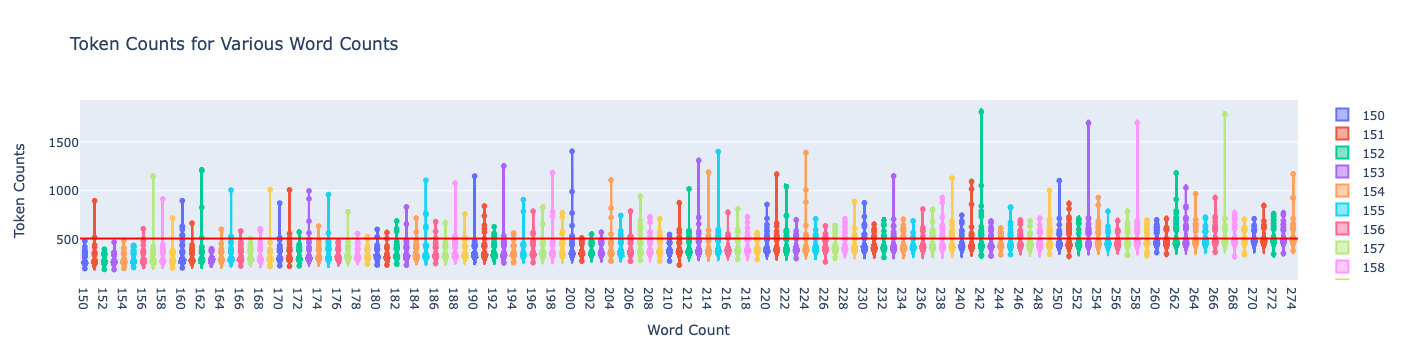

In [12]:
import numpy as np
import plotly.graph_objects as go

# Assuming token_counts is already defined as per previous sections
word_counts = list(token_counts.keys())
all_token_counts = [token_counts[count] for count in word_counts]

# Calculate z-scores for 512 for each word count's token counts
z_scores = {}
for count, counts in zip(word_counts, all_token_counts):
    mean = np.mean(counts)
    std = np.std(counts)
    z_scores[count] = (512 - mean) / std

# Violin plot
fig = go.Figure()

for count, counts in zip(word_counts, all_token_counts):
    z_score_512 = z_scores[count]
    hover_text = f"Word Count: {count}<br>Mean: {np.mean(counts):.2f}<br>Std Dev: {np.std(counts):.2f}<br>Z-score for 512: {z_score_512:.2f}"
    
    fig.add_trace(go.Violin(
        y=counts,
        name=str(count),
        box_visible=True,
        meanline_visible=True,
        hoverinfo="text",
        text=hover_text
    ))

# Add a horizontal line at y=512 using relative positioning
fig.add_shape(
    type="line",
    x0=0,
    x1=1,
    xref="paper",
    y0=512,
    y1=512,
    line=dict(color="Red", width=2)
)

fig.update_layout(
    title="Token Counts for Various Word Counts",
    xaxis_title="Word Count",
    yaxis_title="Token Counts"
)
fig.show()


We should expect some variance (like non-monotonicity) here since we are taking different samples for each word count. There is no right answer, but I'm feeling optimistic around 225, though some might call me a square ;)

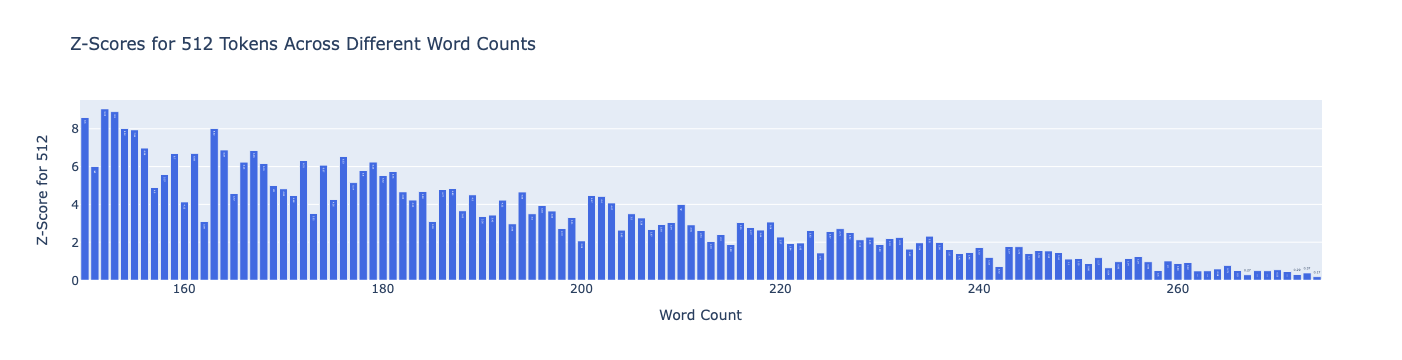

In [13]:
# Assuming token_counts is already defined as per previous sections
word_counts = list(token_counts.keys())
all_token_counts = [token_counts[count] for count in word_counts]

# Calculate z-scores for 512 for each word count's token counts
z_scores_list = []
for count, counts in zip(word_counts, all_token_counts):
    mean = np.mean(counts)
    std = np.std(counts)
    z_score_512 = (512 - mean) / std
    z_scores_list.append(z_score_512)

# Bar chart
fig = go.Figure(go.Bar(
    x=word_counts,
    y=z_scores_list,
    text=np.round(z_scores_list, 2),
    textposition='auto',
    marker_color='royalblue'
))

fig.update_layout(
    title="Z-Scores for 512 Tokens Across Different Word Counts",
    xaxis_title="Word Count",
    yaxis_title="Z-Score for 512"
)
fig.show()